### Import Library

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt     
import scipy

In [2]:
data_root = './dataset image-processing/dataset_ktp_selfie'

### Data generator for training and validation

In [14]:
img_height = 150
img_width = 150
IMAGE_SHAPE = (img_width, img_height)

batch_size = 64

TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.30)
train_datagen = ImageDataGenerator(
    **datagen_kwargs,
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    brightness_range=[0.5,1.5],  
    zoom_range=0.2,
    horizontal_flip=True, 
    preprocessing_function=None, 
    data_format=None, 
    #validation_split=0.2, 
    dtype=None
) # set validation split

valid_datagen = ImageDataGenerator(**datagen_kwargs)



train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
) # set as training data

valid_generator = valid_datagen.flow_from_directory(
    #train_data_dir, # same directory as training data
    TRAINING_DATA_DIR,
    target_size=(img_height, img_width),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle = True,
    subset='validation'
) # set as validation data

Found 1402 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Create TF Model

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape = (img_width, img_height, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(2, activation='sigmoid')  
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [21]:
mc = tf.keras.callbacks.ModelCheckpoint('ktp_selfie_model_01.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model.fit(
            train_generator,
            epochs=20,
            validation_data=valid_generator,
            callbacks = [mc], 
            )

Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.7140
Epoch 1: val_loss improved from inf to 0.57273, saving model to ktp_selfie_model_01.h5
22/22 [==============================] - 10s 435ms/step - loss: 0.5692 - accuracy: 0.7140 - val_loss: 0.5727 - val_accuracy: 0.7450
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8402
Epoch 2: val_loss improved from 0.57273 to 0.48021, saving model to ktp_selfie_model_01.h5
22/22 [==============================] - 9s 416ms/step - loss: 0.4086 - accuracy: 0.8402 - val_loss: 0.4802 - val_accuracy: 0.7467
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8809
Epoch 3: val_loss improved from 0.48021 to 0.41900, saving model to ktp_selfie_model_01.h5
22/22 [==============================] - 9s 420ms/step - loss: 0.3105 - accuracy: 0.8809 - val_loss: 0.4190 - val_accuracy: 0.8000
Epoch 4/20
22/22 [==============================] - ETA

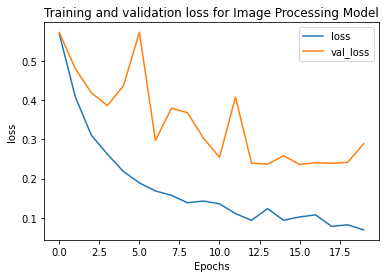

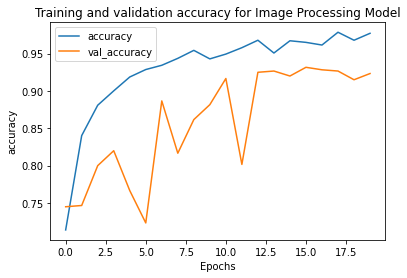

In [23]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.title(f'Training and validation {metric} for Image Processing Model')
    plt.show()
    
plot_graphs(history, "loss")
plot_graphs(history, "accuracy")

In [24]:
import tensorflow as tf
final_model = tf.keras.models.load_model('./ktp_selfie_model_01.h5')

### Plot Model

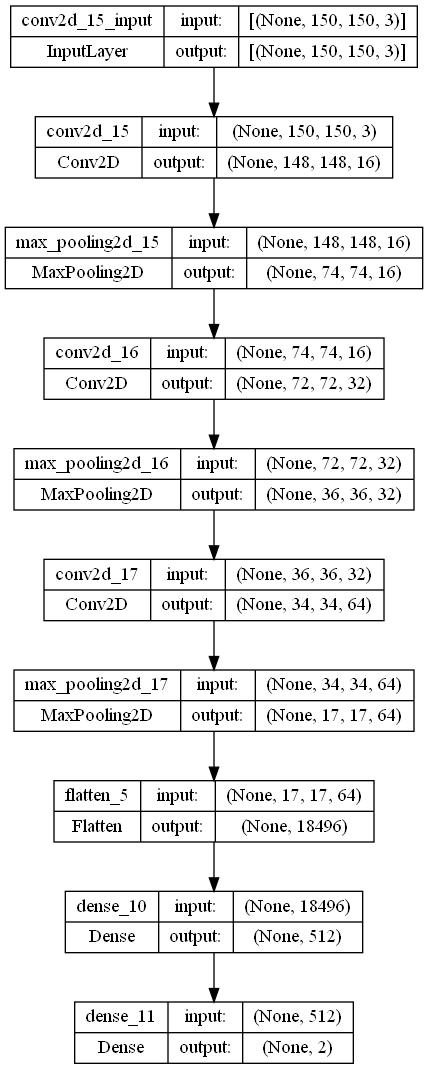

In [25]:
tf.keras.utils.plot_model(final_model, show_shapes=True)

### Confusion Matrix and Classification Report

In [26]:
valid_generator = valid_datagen.flow_from_directory(
    #train_data_dir, # same directory as training data
    TRAINING_DATA_DIR,
    target_size=(img_height, img_width),
    batch_size= batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation'
) # set as validation data

Found 600 images belonging to 2 classes.


In [27]:
predict = final_model.predict(valid_generator)
predictions = []
for i in range(len(predict)):
    predictions.append(np.argmax(predict[i]))

cm = confusion_matrix(valid_generator.classes, predictions)

print(cm)
print(classification_report(valid_generator.classes, predictions))


10/10 [==============================] - 1s 112ms/step
[[283  17]
 [ 24 276]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       300
           1       0.94      0.92      0.93       300

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



[Text(0, 0.5, 'KTP'), Text(0, 1.5, 'Selfie')]

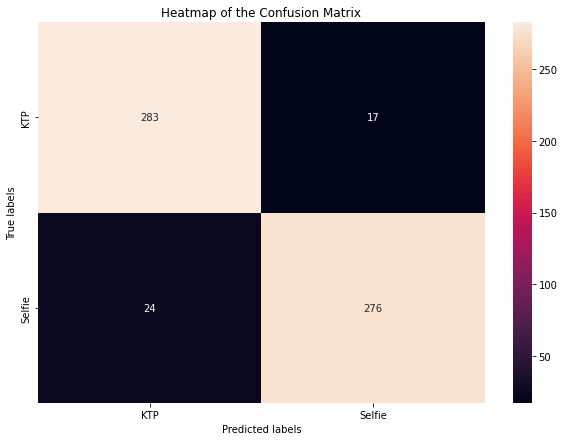

In [28]:
target_names = ['KTP','Selfie']

fig,ax=plt.subplots(1,1,
                    figsize=(10,7)
                   )

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Heatmap of the Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names)

### Check Output Prediction

In [29]:
TEST_DIR = './testing image-processing'

In [31]:
img_height = 150
img_width = 150
datagen_kwargs = dict(rescale=1./255)

test_datagen = ImageDataGenerator(**datagen_kwargs)
test_generator = test_datagen.flow_from_directory(
    #train_data_dir, # same directory as training data
    TEST_DIR,
    target_size=(img_height, img_width),
    shuffle = False,
) # set as validation data

Found 8 images belonging to 1 classes.


#### Show image for testing

(8, 150, 150, 3)


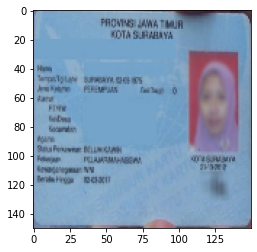

(8, 150, 150, 3)


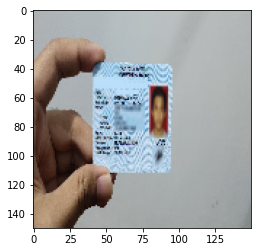

(8, 150, 150, 3)


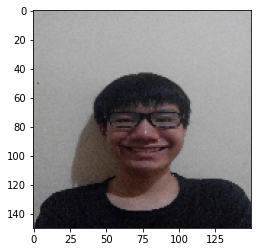

(8, 150, 150, 3)


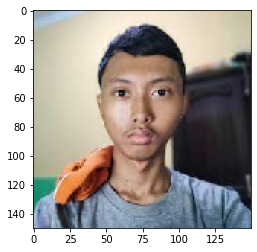

(8, 150, 150, 3)


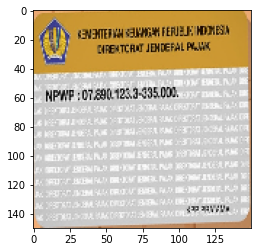

(8, 150, 150, 3)


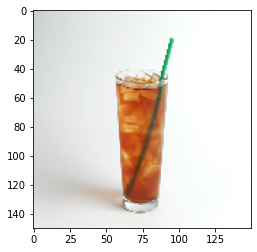

(8, 150, 150, 3)


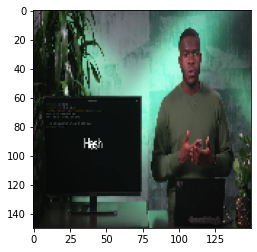

(8, 150, 150, 3)


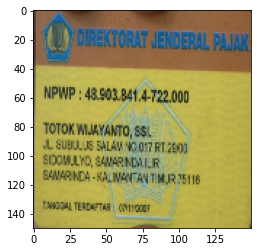

In [32]:
for i in range(8):
    img, label = test_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[i])
    plt.show()

#### Output Prediction

In [33]:
predictions = final_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

1/1 [==============================] - 1s 520ms/step


*set treshold for 90%*

In [34]:
for i in range(8):
    if max(predictions[i]) < 0.9:
        output = 'file unrecognized'
        data = {f"classification for image number {i}": str(output)}
    else:
        if np.argmax(predictions[i]) == 0:
            output = 'ktp'
        else:
            output = 'selfie'
        data = {f"classification for image number {i}": str(output)}
    print(data)

{'classification for image number 0': 'ktp'}
{'classification for image number 1': 'ktp'}
{'classification for image number 2': 'selfie'}
{'classification for image number 3': 'selfie'}
{'classification for image number 4': 'file unrecognized'}
{'classification for image number 5': 'file unrecognized'}
{'classification for image number 6': 'file unrecognized'}
{'classification for image number 7': 'file unrecognized'}


## Convert .h5 model to TFLite

In [35]:
final_model = tf.keras.models.load_model('./ktp_selfie_model_01.h5')

# Check its architecture
final_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 17, 17, 64)      

In [36]:
import tempfile
import os

MODEL_DIR = './exp_ktp_selfie_model_01'

# version = 2

# export_path = os.path.join(MODEL_DIR, str(version))
export_path = os.path.join(MODEL_DIR)

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

INFO:tensorflow:Assets written to: ./exp_ktp_selfie_model_01\assets


INFO:tensorflow:Assets written to: ./exp_ktp_selfie_model_01\assets



export_path = ./exp_ktp_selfie_model_01


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [46]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = 'ktp_selfie_model_01.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

label_types = ['ktp', 'selfie']
with open('ktp_selfie_model_01.txt', 'w') as f:
    f.write('\n'.join(label_types))